In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
qiskit    : 0.24.1 {'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.0', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': None}
numpy     : 1.22.3
matplotlib: 3.5.1


## Hybrid computation
As fault-tolerant quantum computers are far from being available, the attention has moved to algorithms which can be run on the machines that exist now, known as NISQ (Noisy Intermediate Scale Quantum computer). These devices require circuits of shallow depth (i.e., a reduced number of processing steps or gates, which does not require too much coherence) and robust against errors. This can be achieved by hybrid circuits, which integrate quantum and classical computing.

The challenge is that, if we increase the depth of the circuit for better accuracy, the extra decoherence has the effect of adding noise. The performance in noise devices is explored in [6].

## Variational methods
A major class of hybrid algorithms is that made of variational circuits, which are built with parametric circuits, which depend of parameters that can be optimized by classical techniques. Parametric circuits can be thought of as families of circuits. A particular choice for the values of the parameters defines one member of the family.

A variational hybrid algorithm uses a quantum device to compute the value of an objective or cost function $C(\bar{\theta})$ for a given set of real parameters $\bar{\theta}$. To do that the quantum device implements a parametric circuit $U( \bar{ \theta} )$ that prepares a state $U( \bar{ \theta} )|\psi_0\rangle=|\psi(\bar{\theta})\rangle$, where $|\psi_0\rangle $ is an initial state independent of the parameterization, and then performs a measurement using a Hamiltonian projection operator.
A classical processor feeds the quantum circuit the $\theta$'s and treats the quantum circuit as a black box function that is iteratively queried until the optimum is found for a set $\bar{\theta_o}$ . The quality of this optimum, i.e. how well does the solution of the parametric method approach the solution of the original problem, or objective function, depends on the choice of the parametrisation.  

Once we have $\bar{\theta_o}$ , we can create  $U(\bar{\theta_o})|\psi_0\rangle=|\psi(\bar{\theta_o})\rangle$. By sampling this state we obtain a bitstring which, with high probability, is close to the optimum of the objective function. 

In the end we are not after the optimum expectation value, but after the quantum state that is associated with that value as it codes the bitstring that we are after. The bitstring is the solution, not the circuit parameters or the expectation value of the cost function.


## Adiabatic computation
The quantum approximate optimization algorithm (QAOA) is a shallow-circuit variational algorithm for gate-model quantum computers specially suited for optimization problems, that was inspired in adiabatic computation. This is reflected in the specific parametrisation, which allows the hybrid optimisation to closely approximate an adiabatic algorithm.

The adiabatic approach starts with an initial (or mixing) Hamiltonian $H_M$ whose ground state is easy to find. This state is evolved very slowly (adiabatically) to a final 'cost' Hamiltonian $H_C$ whose eigenstates encode the solution. An interpolation Hamiltonian $\tilde{H}$ is used to connect $H_M$ and $H_C$. If the adiabatic conditions are met, the adiabatic theorem guarantees that the system will remain in its mixing ground state and eventually reach the solution at $t=T$.


If $T$ is the time over which the computation is run, we define the dimensionless time $s=t/T$ with $0 \leq s \leq 1$ so that we have:

$$
\tilde{H}(s) = (1-s)H_M + sH_C \tag{1}
$$

So at time $s=0$ our system is governed by $H_M$, at time $s=1$ by $H_C$. Assume that at time $s=0$ we are in the ground state of $H_C$ given by $\lvert\Psi(0)\rangle$. If we evolve our initial state slow enough we end up with the ground state at $s=1$ which corresponds to the ground state of $H_M$, solving the problem we are interested in. The Schrodinger equation tells us that the unitary operator describing the time evolution of a time dependent wave function is given by.

$$
U(t=1,0) = T_{\leftarrow} \exp \left[ -i \int_{0}^1 ds \tilde{H}(s)\right] 
$$

where $T_{\leftarrow} $ ensures that the operators are time ordered, which is relevant if you are writing the exponential as a series. 

$$
 T_{\leftarrow} \exp \left[ -i \int_{0}^1  (1-s) H_M ds -i \int_{0}^1 sH_C ds\right]
$$

We have to use that $\exp(A+B) = \lim_{n\to\infty} (\exp(A/n)\exp(B/n))^n$ (Trotter-Suzuki formula), since $H_M$ and $H_C$ do not commute.

$$
U(t=1,0) = \lim_{n\to\infty} T_{\leftarrow} \prod_j^n \left( \exp \left( -\frac{i}{n}\int_{0}^1  (1-s) H_M ds\right) \exp \left( -\frac{i}{n} \int_{0}^1  s H_C ds\right)\right)_j
$$

Now we can do the integrals, which both give a factor $\frac{1}{2}$.

$$
U(t=1,0) =  \lim_{n\to\infty}  \prod_j^n \left( \exp \left( -\frac{i}{2n} H_M\right) \exp \left( -\frac{i}{2n} H_C\right)\right)_j 
$$


If we now take $p$ discrete steps instead of an infinite number (at the cost of an error $\delta(p^2)$), we get

$$
U(t=1,0) =  \prod_{j=1}^p \left(\exp \left( - \frac{i}{2p} H_M\right) \exp \left( - \frac{i}{2p} H_C\right) \right)_j
$$

Instead of taking discrete equal steps $1/2p$ for both $H_M$ and $H_C$, we take variable size steps $\beta_j, \gamma_j$, where $\beta_j$ and $\gamma_j$ sum to $\frac{1}{2p}$, which finally gives:

$$
\prod_{j=1}^p \exp \left( -i \beta_j H_M\right) \exp \left( -i \gamma_j H_C\right)  = \prod_{j=1}^p U(H_M,\beta_j) U(H_C,\gamma_j)  \equiv  U \tag{2}
$$


## QAOA

The quantum approximate optimization algorithm (QAOA) is a shallow-circuit variational algorithm for gate-model quantum computers specially suited for optimization problems, that was inspired by adiabatic computation. This is reflected in the specific parametrisation, which allows this hybrid optimisation to closely approximate the adiabatic algorithm.

QAOA first generalizes the optimization problem by maximizing (or minimizing) a cost function of the form:

$$
C(b)=\sum_{\alpha =1}^{m}C_\alpha (b)\tag{3}
$$

written as a sum of $m$ clauses $C_\alpha(b)$ on bitstrings $b\in \left \{ 0,1 \right \}^{\otimes n}$ or equivalently spins $z_i \in \left \{ -1,+1 \right \}^{\otimes n}$. In most of practical cases, an Hamiltonian of higher dimension can be written as a weighted sum of local (i.e., 1 or 2 qubit) operator which act on individual qubits.  To build a full $N \times N$ Hamiltonian from $2 \times 2$ Pauli operators we use a tensor product of Identity and Pauli operators like in:

$$
\sigma _{i}^{X}\sigma _{i}^{X} = I\otimes ...\otimes \sigma _{i}^{X} \otimes  ... \sigma _{j}^{X} \otimes ... \otimes I \tag{4}
$$

With this goal,  which we make our system suitable for quantum computation by promoting each spin to a Pauli-Z operator (which has eigenvalues $\pm 1$).

The simplest example of an initial Hamiltonian is one consisting of Pauli operators $H_M = -\sum_j \sigma^X_j$, which incidentally its the same as the initial Hamiltonian in quantum annealing.

To discretize the cost Hamiltonian (so that we can work in gate model), we proceed as follows:

We first define the unitary operator:

$$
U(H_C,\beta ):=exp(-i\beta H_C)=\prod_{\alpha =1}^{m}exp(-i\beta C_\alpha ) \tag{5}
$$

This can be interpreted as simulating $H_C$ during a "time" $\beta$. If we restrict this "time" to be between $0$ and $2\pi$, as the constants $C$ are integer, then we can consider $\beta$ as an angle of rotation which can be implemented with a gate.

Next, for the mixing Hamiltonian we define:

$$
U(H_M,\gamma ):=exp(-i\gamma H_M)=\prod_{j =1}^{m}exp(-i\gamma \sigma _{j}^{X} ) \tag{6}
$$

Where $\sigma _{j}^{X}$ is a Pauli-X operator applied to $j$.


By alternately applying $U(H_M,\beta )$  and $U(H_M,\gamma )$ we get an expression that generalizes eqn (2)

$$
U = U(H_M,\beta_0 )U(H_M,\gamma_0 )\ldots U(H_M,\beta_p )U(H_M,\gamma_p ) \tag{7}
$$

Finally we minimize the objective function $F_p(\bar{\beta},\bar{\gamma})$ over all $\beta_i$'s and $\gamma_i$'s 


$$
F_p(\bar{\beta},\bar{\gamma})= \langle \bar{\beta},\bar{\gamma}|H_C|\bar{\beta},\bar{\gamma} \rangle \tag{8}
$$

It can be proven using the adiabatic theorem 

$$
\lim_{p\to\infty } max_{\beta , \gamma }\left ( F_{p}\left ( \bar{\beta} ,\bar{ \gamma} \right ) \right ) =max_{b }\left ( C\left ( b \right ) \right )
$$


<br>
<img src="../../figures/pathways.png" alt="Conceptual comparison of analog Adiabatic (top), quantum simulated adiabatic (middle) and QAOA pathways (bottom)" style="width: 600px;"/>

Conceptual comparison of analog Adiabatic (top), quantum simulated adiabatic (middle) and QAOA pathways (bottom). Modelled after [7]



## Algorithm

1. We start with an initial state that is an equal superposition over all bitstrings:

$$
\left |  \psi_0 \right \rangle = \frac{1}{\sqrt{2^{n}}}\sum_{i=1}^n \left |  + \right \rangle_i
$$
   by applying a Hadamard to each qubit $H^{\otimes n} \left |  0 \right \rangle ^{\otimes n}$

2. Evolve the system with the cost Hamiltonian by applying $U(H_C,\beta )$ for an angle $\beta$.
3. Evolve the system with the mixing Hamiltonian by applying $U(H_M,\gamma )$ for an angle $\gamma$.
4. Repeat the steps (2) and (3) $p$ times with different parameters $\beta_j,\gamma_j$ in each step $j=1,...,p$, obtaining the state:
$$
|\bar{\beta},\bar{\gamma}  \rangle = \prod_{j=1}^{p}U(H_M,\gamma_j)U(H_C,\beta_j)|\psi_0 \rangle
$$
5. Measure in the computational basis to get the expectation value of $H_C$:
$$
F_p(\bar{\beta},\bar{\gamma})= \langle \bar{\beta},\bar{\gamma}|H_C|\bar{\beta},\bar{\gamma} \rangle
$$
6. Approximate the maximum or minimum of $F_p(\bar{\beta},\bar{\gamma})$
7. Run the circuit many times. The most probable bitstring correspond to the optimum value of the cost function

<img src="../../figures/QAOA-schema.png" alt="schematic diagram of the steps in the QAOA algorithm" style="width: 600px;"/>

Schematic diagram of the steps in the QAOA algorithm




# Implementation example
As an example, we will minimize the cost function $H_c=-\sigma^Z_1 \otimes \sigma^Z_2$ corresponding to the Ising problem, whose minimum is reached whenever $\sigma^Z_1 = \sigma^Z_2$ (for the states $|-1, -1\rangle$, $|11\rangle$ or any superposition of both)

Lets begin by importing the required packages.


In [2]:
import itertools
import numpy as np
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from scipy.optimize import minimize
np.set_printoptions(precision=3, suppress=True)

This whole notebook example is built on an example with just 2 qubits. We define some of the basic variables that we will repeatedly need already here

In [3]:
n_qubits = 2
q = QuantumRegister(n_qubits)
c = ClassicalRegister(n_qubits)
circuit = QuantumCircuit(q, c)

First create the initial state by applying a Hadamard, H (not to be confused with the Hamiltonians, $H_C$ and $H_M$) to each qubit

$$
\left |  \psi_0 \right \rangle =H^{\otimes n} \left |  0 \right \rangle ^{\otimes n}
$$

In [4]:
for i in range(n_qubits):
    circuit.h(q[i])

Next we need evolution operators for $H_C$ and $H_M$ 

For a simple 2-bit case we can write $H_C  = - \sum_{i,j}\sigma_j^Z\sigma_i^Z$, as a simple 4x4 diagonal matrix:

$$\sigma^Z =  \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}\text{, so } \sigma_j^Z\sigma_i^Z  = 
 \begin{pmatrix}
1 & 0  & 0  &0 \\
0 & -1 & 0  &0 \\
0 & 0  & -1 &0 \\
0 & 0  & 0  &1
\end{pmatrix} $$

Hence the evolution of $H_C$ for a period $\gamma$ , $e^{-j\gamma H_C}$ can be written as:
<br>

$$exp(j\gamma\sigma_j^Z\sigma_i^Z) =   \begin{pmatrix}
e^{j\gamma} & 0  & 0  &0 \\
0 & e^{-j\gamma} & 0  &0 \\
0 & 0  &e^{-j\gamma} &0 \\
0 & 0  & 0  &e^{j\gamma}
\end{pmatrix} $$

For a 2-bit system an $R_z(2\gamma)$ on the second qubit equals the matrix:

 $R_z(2\gamma) = \begin{pmatrix}
e^{j\gamma} & 0  & 0  &0 \\
0 & e^{-j\gamma} & 0  &0 \\
0 & 0  &e^{j\gamma} &0 \\
0 & 0  & 0  &e^{-j\gamma}
\end{pmatrix} $.

Applying a CX(0,1) operation before and after the  $R_z(2\gamma)$ swaps the last two elements on the diagonal. So we can implement the evolution operator for $H_C$ with a sequence CX(0,1).Rz($\gamma$,1).CX(0,1)

As we have seen, the simplest mixing Hamiltonian most frequently used is is one consisting of Pauli $\sigma^X$ operators

 $H_M = -\sum_j \sigma^X_j$

as $\sigma^X =  \begin{pmatrix}
0 &1 \\
1 & 0
\end{pmatrix} $ it can easily be shown by a Taylor expansion of the exponent that the evolution of $H_M$ on a single qubit for a period $\beta$ equals

$exp\left(-j \beta H_M\right)  = exp(j\beta\sigma^X)=  \begin{pmatrix}
cos(\beta) &-jsin(\beta) \\
-jsin(\beta) & cos(\beta)
\end{pmatrix} $ , 

which is an $R_x$ rotation over $2\beta$.

Hence we can implement the evolution of $H_M$ for a period $\beta$ as an application of $R_x(2\beta)$ on all individual qubits.

In [5]:
# We define the number of steps p, and some randomly chosen beta's and gamma's
p = 2

beta = np.random.uniform(0, 2*np.pi, p)
gamma = np.random.uniform(0, 2*np.pi, p)

In [6]:
# Run onlu once! 
# We apply now the evolution operators
for i in range(p):
    # apply gamma's
    circuit.cx(q[0],q[1])
    circuit.rz(2*gamma[i],q[1])
    circuit.cx(q[0],q[1])
    # apply beta's
    circuit.rx(2*beta[i], q[0])
    circuit.rx(2*beta[i], q[1])

In [8]:
print(circuit)

      ┌───┐                        ┌────────────┐                         »
q0_0: ┤ H ├──■──────────────────■──┤ Rx(7.9754) ├──■───────────────────■──»
      ├───┤┌─┴─┐┌────────────┐┌─┴─┐├────────────┤┌─┴─┐┌─────────────┐┌─┴─┐»
q0_1: ┤ H ├┤ X ├┤ Rz(4.8475) ├┤ X ├┤ Rx(7.9754) ├┤ X ├┤ Rz(0.37386) ├┤ X ├»
      └───┘└───┘└────────────┘└───┘└────────────┘└───┘└─────────────┘└───┘»
c0: 2/════════════════════════════════════════════════════════════════════»
                                                                          »
«      ┌────────────┐
«q0_0: ┤ Rx(9.7333) ├
«      ├────────────┤
«q0_1: ┤ Rx(9.7333) ├
«      └────────────┘
«c0: 2/══════════════
«                    


Finally we need to compute the expectation value for the energy $F_p(\bar{\beta},\bar{\gamma})$ for these particular values of the parameters $\bar{\beta}$ and $\bar{\gamma}$ 

We use the state simulator to compute the vector representation of the state $|\bar{\beta}, \bar{\gamma}>$. As $H_C$  is diagonal in the computational (i.e. z-) basis we can easily calculate the matrix product $ \langle\bar{\beta},\bar{\gamma}|H_C|\bar{\beta},\bar{\gamma}  \rangle$ to get the expectation value for the energy. 


In [11]:
#compute statevector |β, γ>
backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
state = np.asarray(job.result().get_statevector(circuit))
# compute expectation <β,γ|Hc|β,γ>
pauli_z = np.array([[1,0],[0,-1]])
H = np.kron(pauli_z, pauli_z)
H_expectation = -1*state @ H @ state.conj().T
   
print('Expectation value for cost Hamiltonian: ', H_expectation)

Expectation value for cost Hamiltonian:  (-0.7408873059364516+0j)


We will now put all these steps into a callback routine that is required for the optimization. The minimize routine from Scipy varies a single np.array [beta_gamma] that holds the parameters,  $\bar{\beta}$ and  $\bar{\gamma}$, to minimize the Hamiltonian objective $F_p(\bar{\beta},\bar{\gamma})= \langle \bar{\beta},\bar{\gamma}|H_C|\bar{\beta},\bar{\gamma} \rangle$. 

In [12]:
def evaluate_cost_hamiltonian(beta_gamma):
    
# extract the beta's and the gamma's from the single parameter np.array
    n = len(beta_gamma)//2
    beta  = beta_gamma[:n]
    gamma = beta_gamma[n:]

# Define a 'clean' circuit and initiate the qubits to a full superposition initial state
    n_qubits = 2
    circuit = QuantumCircuit(q, c)
    for i in range(n_qubits):
        circuit.h(q[i])

    for i in range(p):
        # apply gamma's
        circuit.cx(q[0],q[1])
        circuit.rz(2*gamma[i],q[1])
        circuit.cx(q[0],q[1])
        # apply beta's
        circuit.rx(2*beta[i], q[0])
        circuit.rx(2*beta[i], q[1])
        
#compute statevector
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    state = np.asarray(job.result().get_statevector(circuit))
        
# compute expectation
    pauli_z = np.array([[1,0],[0,-1]])
    H = np.kron(pauli_z, pauli_z)
    H_expectation = -1*state @ H @ state.conj().T

    return np.real(H_expectation)

With the cost function defined, we can now run the Scipy minimize function with the optimization method of our choice.

In [13]:
# Choose the number of steps, p, and initiate the gamma's and beta's accordingly
p = 2

beta = np.random.uniform(0, 2*np.pi, p)
gamma = np.random.uniform(0, 2*np.pi, p)

result = minimize(evaluate_cost_hamiltonian, np.concatenate([beta, gamma]), method='L-BFGS-B')
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.9999999999992912
        x: [ 3.365e+00  5.870e+00  6.231e+00  2.389e+00]
      nit: 7
      jac: [-5.107e-07 -2.898e-06 -6.661e-08 -1.887e-06]
     nfev: 45
     njev: 9
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

# Analysis of the results

We create a circuit using the optimal parameters $\bar{\beta_o}$,$\bar{\gamma_o}$ found.

In [14]:
# extract the optimal β's and γ's from the result.x attribute

beta  = result.x[:p]
gamma = result.x[p:]

#Create the initial state Ψ0  
n_qubits = 2
circuit = QuantumCircuit(q, c)
for i in range(n_qubits):
    circuit.h(q[i])    

#apply the evolution unitaries

for i in range(p):
    # apply gamma's
    circuit.cx(q[0],q[1])
    circuit.rz(-2*gamma[i],q[1])
    circuit.cx(q[0],q[1])
    # apply beta's
    circuit.rx(-2*beta[i], q[0])
    circuit.rx(-2*beta[i], q[1])

We use the `statevector_simulator` backend in order to display the state created by the circuit.

In [17]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
state = np.asarray(job.result().get_statevector(circuit))
print(state)
print(np.abs(state))


[-0.667+0.236j  0.   +0.j     0.   +0.j    -0.667+0.236j]
[0.707 0.    0.    0.707]


We see that the state is approximately $e^{i \theta} \frac{1}{\sqrt{2}} \left( |00 \rangle + |11 \rangle \right)$, where $\theta$ is a phase factor that doesn't change the probabilities. It corresponds to a uniform superposition of the two solutions of the classical problem: $(\sigma_1=1$, $\sigma_2=1)$ and $(\sigma_1=-1$, $\sigma_2=-1)$

## Further considerations

The example above has show that a simple parametarisation of the operator space can be effective in locating the solution of our optimization problem. However, as you may have spotted, we did not use a true quantum algorithm, as the computation of the expectation value was based on an explicit computation of H through the wavefunction simulator. So essentially we did a classical exhaustive calculation of all the eigenvalues. When the number of qbits increases it is exactly this calculation that becomes impossible on a classical device and is the reason we need to switch over to a true quantum machine. 

In the next section we rebuild the algorithm, but this time we use the regular quantum simulator for the evaluation of the objective function, and likewise for the evaluation of the resulting circuit. The probabilistic nature of our quantum output will produce ' noisy' derivatives that will confuse algorithms that rely on a gradient calculation, like the 'L-BFGS-B' algorithm. Therefor we use a gradient-free method like ' COBYLA' or 'Nelder-Mead' as our classical optimization algorithm.


$$
\left<H\right>=\left<-\sum_{ij}\sigma_i\sigma_j\right>, \quad \sigma \in \left\{ -1,1 \right\}
$$

As the qubit values are +/-1 we need to transform this expresssion substituting

$$\sigma = 2*(q-1),\quad q \in \left\{ 0,1 \right\},\sigma \in \left\{ -1,1 \right\}$$
to yield

\begin{align}
\left<H\right>&=-\left<\sum_{ij}(2*q_i-1)(2*q_j-1)\right>, \quad q \in \left\{ 0,1 \right\} \\
&=-\sum_{ij}p_{ij}(2*q_i-1)(2*q_j-1),   \\
\end{align}


with $p_{ij}$ the probability of finding qubits i,j in a specific state. Running $N=\sum_{ij} m_{ij}$ simulations this is approximated by:


$$
\left<H\right> \approx -\sum_{ij}\frac{m_{ij}}{N}(2*q_i-1)(2*q_j-1)
$$



Use the quantum simulator from this point forward

In [18]:
backend = Aer.get_backend('qasm_simulator')

In [19]:
def evaluate_quantum_cost_hamiltonian(beta_gamma):
    
# extract the beta's and the gamma's from the single parameter np.array
    n = len(beta_gamma)//2
    beta  = beta_gamma[:n]
    gamma = beta_gamma[n:]

# Define a 'clean' circuit and initiate the qubits to a full superposition initial state
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n_qubits):
        circuit.h(q[i])

    for i in range(p):
        # apply gamma's
        circuit.cx(q[0],q[1])
        circuit.rz(2*gamma[i],q[1])
        circuit.cx(q[0],q[1])
        # apply beta's
        circuit.rx(2*beta[i], q[0])
        circuit.rx(2*beta[i], q[1])
        
   
    circuit.measure(q, c)
    shots = 500
    job = execute(circuit, backend, shots=shots)

    result = job.result().get_counts(circuit)

# compute expectation
    H_expectation = 0
    for i in range(n_qubits):
        for j in range(n_qubits):
            multiplicity = result.get(str(i)+str(j), 0)
            H_expectation -= multiplicity*(2*i-1)*(2*j-1)
            # here we explicitly assume that n_qubits = 0/1

    H_expectation /= shots
    return np.real(H_expectation)

In [20]:
# Choose the number of steps, p, and initiate the gamma's and beta's accordingly

p = 2
n_qubits = 2
beta = np.random.uniform(0, 2*np.pi, p)
gamma = np.random.uniform(0, 2*np.pi, p)

result = minimize(evaluate_quantum_cost_hamiltonian, np.concatenate([beta, gamma]), method='COBYLA')
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0
       x: [ 2.972e+00  1.802e+00  2.258e+00  4.817e+00]
    nfev: 40
   maxcv: 0.0

In [25]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)

# extract the optimal β's and γ's from the result.x attribute

beta  = result.x[:p]
gamma = result.x[p:]

#Create the initial state Ψ0  
n_qubits = 2
circuit = QuantumCircuit(q, c)
for i in range(n_qubits):
    circuit.h(q[i])    

#apply the evolution unitaries

for i in range(p):
    # apply gamma's
    circuit.cx(q[0],q[1])
    circuit.rz(-2*gamma[i],q[1])
    circuit.cx(q[0],q[1])
    # apply beta's
    circuit.rx(-2*beta[i], q[0])
    circuit.rx(-2*beta[i], q[1])
circuit.measure(q, c)
print(circuit)

        ┌───┐                         ┌─────────────┐                         »
q457_0: ┤ H ├──■───────────────────■──┤ Rx(-5.9446) ├──■───────────────────■──»
        ├───┤┌─┴─┐┌─────────────┐┌─┴─┐├─────────────┤┌─┴─┐┌─────────────┐┌─┴─┐»
q457_1: ┤ H ├┤ X ├┤ Rz(-4.5152) ├┤ X ├┤ Rx(-5.9446) ├┤ X ├┤ Rz(-9.6339) ├┤ X ├»
        └───┘└───┘└─────────────┘└───┘└─────────────┘└───┘└─────────────┘└───┘»
 c41: 2/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌─────────────┐┌─┐   
«q457_0: ┤ Rx(-3.6037) ├┤M├───
«        ├─────────────┤└╥┘┌─┐
«q457_1: ┤ Rx(-3.6037) ├─╫─┤M├
«        └─────────────┘ ║ └╥┘
« c41: 2/════════════════╩══╩═
«                        0  1 


In [27]:
shots = 1000
job = execute(circuit, backend, shots=shots)

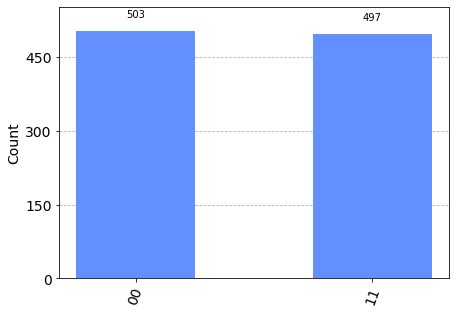

In [28]:

result = job.result().get_counts()
plot_histogram(job.result().get_counts(circuit))

Within reasonable accuracy the result is the same as achived by the analytic method

## Bibliography 

$[1] \hspace{1cm} \textit{Adiabatic Quantum Simulation using Trotterization}$, Yifan Sun et al, https://arxiv.org/pdf/1805.11568.pdf

$[2] \hspace{1cm} \textit{Adiabatic Quantum Computation and Quantum Annealing}$, Catherine C. McGeoch, MC Publishers 2014

$[3] \hspace{1cm}\textit{Supervised Learning with Quantum Computers}$, Maria Schuld & Francesco Petruccione, Springer 2018

$[4] \hspace{1cm}\textit{Quantum Computing: An Applied Approach}$, Jack D. Hidary, Springer 2019

$[5] \hspace{1cm}\textit{Quantum Computation by Adiabatic Evolution}$, Edward Farhi & Jeffrey Goldstone, https://arxiv.org/abs/quant-ph/0001106

$[6] \hspace{1cm}\textit{Analysis of Quantum Approximate Optimization Algorithm under Realistic Noise in Superconducting Qubits}$, Mahabubul Alam, https://arxiv.org/pdf/1907.09631.pdf

$[7] \hspace{1cm}\textit{A Quantum Algorithm To Train Neural Networks Using Low-depth Circuits}$, Guillaume Verdon et al. https://arxiv.org/abs/1712.05304